<a href="https://colab.research.google.com/github/nantmoe-theingi/airbnb-nz-deception-sentiment/blob/main/notebooks/03_svm_sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import re

# Load the data
CSV = "data/tripadvisor_hotel_reviews.csv"
df = pd.read_csv(CSV)
print(df.head())
print("Numbers of reviews:", len(df))
# Show unique values in the 'rating' column
print("unique values in the 'rating' column:", df["Rating"].unique())

                                              Review  Rating
0  nice hotel expensive parking got good deal sta...       4
1  ok nothing special charge diamond member hilto...       2
2  nice rooms not 4* experience hotel monaco seat...       3
3  unique, great stay, wonderful time hotel monac...       5
4  great stay great stay, went seahawk game aweso...       5
Numbers of reviews: 20491
unique values in the 'rating' column: [4 2 3 5 1]


In [ ]:
from langdetect import detect

# Safe language detection
def detect_lang(text):
    try:
        return detect(text) if isinstance(text, str) and text.strip() else "unknown"
    except:
        return "error"

# Detect language for each review
df["language"] = df["Review"].apply(detect_lang)

# Show language distribution
print("Detected languages distribution:")
print(df["language"].value_counts())

# Filter to English only
english_df = df[df["language"] == "en"].copy()

# Show before/after counts
print("\nTotal reviews before filtering:", len(df))
print("Total English-only reviews after filtering:", len(english_df))
print(f"Removed {len(df) - len(english_df)} non-English or undetectable reviews.")

# Replace df with English-only data
df = english_df.reset_index(drop=True)

print("\n DataFrame updated — only English reviews retained.")
print("New length of df:", len(df))


Detected languages distribution:
language
en    20473
fr       10
af        4
es        1
ro        1
ca        1
nl        1
Name: count, dtype: int64

Total reviews before filtering: 20491
Total English-only reviews after filtering: 20473
Removed 18 non-English or undetectable reviews.

 DataFrame updated — only English reviews retained.
New length of df: 20473


In [ ]:
TEXT_COL = "Review"
RATING_COL = "Rating"

# === 2) Basic cleaning ===
def norm_ws(s: pd.Series) -> pd.Series:
    zws = r'[\u200B-\u200D\uFEFF]'
    s = s.astype(str).str.replace(zws, "", regex=True)
    return s.str.replace(r"\s+", " ", regex=True).str.strip()

df[TEXT_COL] = norm_ws(df[TEXT_COL])
df[RATING_COL] = pd.to_numeric(df[RATING_COL], errors="coerce")

# Drop rows with missing text or rating
before = len(df)
df = df.dropna(subset=[TEXT_COL, RATING_COL]).copy()
df = df.loc[df[TEXT_COL].str.len() > 0]
print(f"Removed {before - len(df):,} rows with missing/empty text or rating.")


Removed 0 rows with missing/empty text or rating.


In [ ]:
# Remove exact duplicate texts
dup_texts = df.duplicated(subset=[TEXT_COL]).sum()
df = df.drop_duplicates(subset=[TEXT_COL]).copy()
print(f"Removed {dup_texts:,} duplicate review texts.")

# remove symbol-only reviews
import regex as re
def is_symbol_only(x: str) -> bool:
    return not bool(re.search(r"\p{L}", x, flags=re.UNICODE))
sym = df[TEXT_COL].apply(is_symbol_only).sum()
df = df.loc[~df[TEXT_COL].apply(is_symbol_only)].copy()
print(f"Removed {sym:,} symbol-only reviews.")

Removed 0 duplicate review texts.
Removed 0 symbol-only reviews.


In [ ]:
# Map rating -> 3-class sentiment
def map_sentiment(star: float) -> str:
    if star <= 2:
        return "negative"
    elif star == 3:
        return "neutral"
    else:  # 4–5
        return "positive"

df["sentiment"] = df[RATING_COL].apply(map_sentiment)

# numeric y for models
label_map = {"negative": 0, "neutral": 1, "positive": 2}
df["y"] = df["sentiment"].map(label_map).astype(int)

print(df.head())

                                              Review  Rating language  \
0  nice hotel expensive parking got good deal sta...       4       en   
1  ok nothing special charge diamond member hilto...       2       en   
2  nice rooms not 4* experience hotel monaco seat...       3       en   
3  unique, great stay, wonderful time hotel monac...       5       en   
4  great stay great stay, went seahawk game aweso...       5       en   

  sentiment  y  
0  positive  2  
1  negative  0  
2   neutral  1  
3  positive  2  
4  positive  2  


In [ ]:
# EDA
print("\nClass distribution:")
print(df["sentiment"].value_counts().sort_index())
print("\nClass distribution (%):")
print((df["sentiment"].value_counts(normalize=True)*100).round(2).sort_index())

df["length_words"] = df[TEXT_COL].str.split().apply(len)
print("\nLength (words): mean=", round(df["length_words"].mean(),2),
      "min=", df["length_words"].min(), "max=", df["length_words"].max())


Class distribution:
sentiment
negative     3210
neutral      2183
positive    15080
Name: count, dtype: int64

Class distribution (%):
sentiment
negative    15.68
neutral     10.66
positive    73.66
Name: proportion, dtype: float64

Length (words): mean= 104.45 min= 7 max= 1931


In [ ]:
# Keep only that need for modeling and save cleaned file
out = df[[TEXT_COL, "sentiment", "y"]].rename(columns={TEXT_COL: "text"})
out.to_csv("data/tripadvisor_prepared_3class.csv", index=False)
print("\nSaved: tripadvisor_prepared_3class.csv")


Saved: tripadvisor_prepared_3class.csv


Counts:
 sentiment
Negative     3210
Neutral      2183
Positive    15080
Name: count, dtype: int64

Percentages (%):
 sentiment
Negative    15.68
Neutral     10.66
Positive    73.66
Name: count, dtype: float64


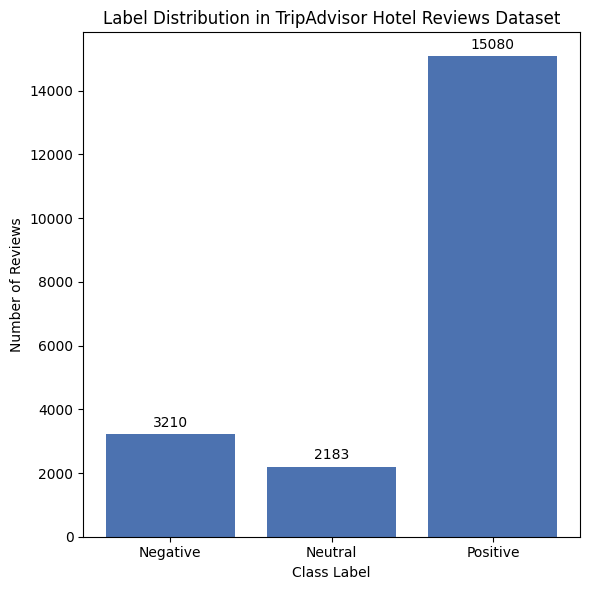

In [ ]:
# plotting
import matplotlib.pyplot as plt

label_type = {"negative": "Negative", "neutral": "Neutral", "positive": "Positive"}
counts = df["sentiment"].value_counts().rename(index=label_type).sort_index()


pct = (counts / counts.sum() * 100).round(2)
print("Counts:\n", counts)
print("\nPercentages (%):\n", pct)

# Plot
plt.figure(figsize=(6,6))
bars = plt.bar(counts.index, counts.values, color="#4C72B0")
plt.title("Label Distribution in TripAdvisor Hotel Reviews Dataset")
plt.xlabel("Class Label")
plt.ylabel("Number of Reviews")

# Add labels
for b in bars:
    y = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, y + max(counts.values)*0.01, f"{int(y)}", ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig("figures/tripadvisor_dataset_distribution.png", dpi=300)
plt.show()

In [ ]:
# 3-class sentiment: TF–IDF + LinearSVC
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
import joblib
import matplotlib.pyplot as plt

In [ ]:
RANDOM_STATE = 42
ARTIFACTS = Path("artifacts/sentiment_svm")
ARTIFACTS.mkdir(parents=True, exist_ok=True)

In [ ]:
# Load prepared file
df_cleaned = pd.read_csv("data/tripadvisor_prepared_3class.csv")

LABEL_COL = "y"
TEXT_COL  = "text"

In [ ]:
RANDOM_SEED = 42
train_df, test_df = train_test_split(
    df_cleaned[[TEXT_COL, LABEL_COL]], test_size=0.15, random_state=RANDOM_SEED,
    stratify=df[LABEL_COL]
)
train_df, val_df = train_test_split(
    train_df, test_size=0.1765, random_state=RANDOM_SEED,  # ~15% of total
    stratify=train_df[LABEL_COL]
)

In [ ]:
print(f"Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

Train=14330, Val=3072, Test=3071


In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(sorted(train_df[LABEL_COL].unique()))
class_weights = compute_class_weight("balanced", classes=classes, y=train_df[LABEL_COL])
class_weights = {int(c):float(w) for c,w in zip(classes, class_weights)}
print(class_weights)

{0: 2.125797359442219, 1: 3.1260907504363002, 2: 0.4525501342175904}


In [ ]:
label_names = {0:"negative", 1:"neutral", 2:"positive"}

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
import joblib

svm_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=2,
        max_df=0.95,
        sublinear_tf=True
    )),
   ("clf", LinearSVC(class_weight=class_weights))
])

param_grid = {
    "tfidf__min_df": [2, 5],
    "tfidf__max_df": [0.9, 0.95],
    "clf__C": [0.25, 0.5, 1.0, 2.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
grid = GridSearchCV(
    svm_pipe, param_grid=param_grid, cv=cv, n_jobs=-1, verbose=1, scoring="f1_macro"
)
grid.fit(train_df[TEXT_COL], train_df[LABEL_COL])

print("Best params:", grid.best_params_)
best_svm = grid.best_estimator_
pred_val = best_svm.predict(val_df[TEXT_COL])
print(classification_report(val_df[LABEL_COL], pred_val, target_names=[label_names[i] for i in sorted(label_names)]))

# test
best_svm.fit(pd.concat([train_df[TEXT_COL], val_df[TEXT_COL]]),
             pd.concat([train_df[LABEL_COL], val_df[LABEL_COL]]))
pred_test = best_svm.predict(test_df[TEXT_COL])

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best params: {'clf__C': 0.25, 'tfidf__max_df': 0.9, 'tfidf__min_df': 5}
              precision    recall  f1-score   support

    negative       0.77      0.83      0.80       481
     neutral       0.50      0.29      0.37       328
    positive       0.92      0.96      0.94      2263

    accuracy                           0.87      3072
   macro avg       0.73      0.70      0.70      3072
weighted avg       0.85      0.87      0.86      3072



In [ ]:
print("\nTest")
print("Accuracy:", accuracy_score(test_df[LABEL_COL], pred_test))
print("Macro-F1:", f1_score(test_df[LABEL_COL], pred_test, average="macro"))
print(classification_report(test_df[LABEL_COL], pred_test, target_names=["negative","neutral","positive"]))


Test
Accuracy: 0.8658417453598176
Macro-F1: 0.7006999380332714
              precision    recall  f1-score   support

    negative       0.77      0.82      0.79       482
     neutral       0.50      0.29      0.37       327
    positive       0.92      0.96      0.94      2262

    accuracy                           0.87      3071
   macro avg       0.73      0.69      0.70      3071
weighted avg       0.85      0.87      0.85      3071



In [ ]:
cm = confusion_matrix(test_df[LABEL_COL], pred_test)
print("Confusion matrix (test):\n", cm)

Confusion matrix (test):
 [[ 397   35   50]
 [  84   96  147]
 [  36   60 2166]]


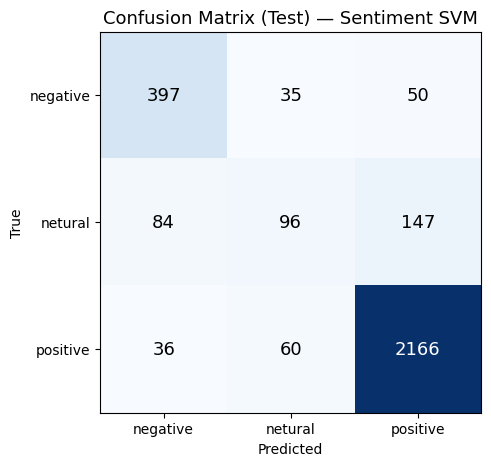

In [ ]:
# CM plot
plt.figure(figsize=(5, 5))
plt.imshow(cm, interpolation="nearest", cmap="Blues")
plt.title("Confusion Matrix (Test) — Sentiment SVM", fontsize=13)
plt.xticks([0,1,2], ["negative","netural","positive"])
plt.yticks([0,1,2], ["negative","netural","positive"])
plt.xlabel("Predicted")
plt.ylabel("True")

for (i, j), v in np.ndenumerate(cm):
    color = "white" if v > cm.max() / 2 else "black"
    plt.text(j, i, str(v), ha="center", va="center", color=color, fontsize=13)

plt.tight_layout()
plt.show()


In [ ]:
# Save artifacts
joblib.dump(best_svm, ARTIFACTS / "svm_sentiment_pipeline.joblib")
joblib.dump({"negative":0, "neutral":1, "positive":2}, ARTIFACTS / "label_map.joblib")
print("Saved model + label map to:", ARTIFACTS.resolve())

Saved model + label map to: /content/drive/MyDrive/Colab Notebooks/airbnb_nz_deception_sentiment/artifacts/sentiment_svm


In [ ]:
# Inference helper
def predict_sentiment(texts, model_path="artifacts/sentiment_svm/svm_sentiment_pipeline.joblib"):
    model = joblib.load(model_path)
    return model.predict(pd.Series(texts))  # returns numeric labels 0/1/2

In [ ]:
texts = [
    "The place was amazing and the host was very friendly!",
    "It was okay, not great but not terrible either.",
    "Terrible experience — the room was dirty and noisy."
]

preds = predict_sentiment(texts)
print(preds)

[2 0 0]


In [ ]:
# model comparison for SVM (sentiment)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd

# Evaluate SVM predictions on test set
svm_results = {
    "Model": "SVM (TF–IDF)",
    "Accuracy": round(accuracy_score(test_df[LABEL_COL], pred_test), 2),
    "Macro-F1": round(f1_score(test_df[LABEL_COL], pred_test, average="macro"), 2),
    "Precision": round(precision_score(test_df[LABEL_COL], pred_test, average="macro"), 2),
    "Recall": round(recall_score(test_df[LABEL_COL], pred_test, average="macro"), 2)
}

# Create dataframe or append to file
try:
    df = pd.read_csv("figures/model_comparison_sentiment.csv")
except FileNotFoundError:
    df = pd.DataFrame(columns=["Model", "Accuracy", "Macro-F1", "Precision", "Recall"])

df = pd.concat([df, pd.DataFrame([svm_results])], ignore_index=True)

# Save updated comparison table
df.to_csv("figures/model_comparison_sentiment.csv", index=False)
print("Added SVM results to model_comparison_sentiment.csv")


Added SVM results to model_comparison_sentiment.csv


/tmp/ipython-input-56992710.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([svm_results])], ignore_index=True)
